# Config

In [1]:
#VERSION = 'focal_loss-161120200048'
#VERSION = 'release_focal_loss'
VERSION = 'final'
OVERWRITE_CHECKPOINT = True    
RECOVER_PAST_TRAINNING = False
TRAIN = False
# Rsp swin t from https://github.com/ViTAE-Transformer/ViTAE-Transformer-Remote-Sensing
# loss function imbalanced classes

import sys
RunningInCOLAB = 'google.colab' in sys.modules

BATCH_SIZE = 4
if RunningInCOLAB:
    BATCH_SIZE = 64

FEATURES = 17
IMG_SIZE = 224
LR = 1e-4
LR_STEP_SIZE = 30
GAMMA = 0.9
N_EPOCHS = 6
MODEL_ARCH = ['rsp-swin-t', 'rsp-resnet-50', 'swin_t_IMAGENET', 'resnet50_IMAGENET']

#MODEL = 'rsp-swin-t'
MODEL = 'rsp-resnet-50'


weights_models = {'rsp-swin-t': 'rsp-swin-t-ckpt.pth', 'swin_t_IMAGENET': 'IMAGENET1K_V1',
                      'rsp-resnet-50' : 'rsp-resnet-50-ckpt.pth', 'resnet50_IMAGENET':'' }

weights_filename = weights_models[MODEL]

config = {"BATCH_SIZE": BATCH_SIZE,"IMG_SIZE": IMG_SIZE,"LR": LR,"LR_STEP_SIZE": LR_STEP_SIZE,
          "GAMMA": GAMMA,"N_EPOCHS": N_EPOCHS,"VERSION": VERSION,"PRETRAIN_WEIGHTS": weights_filename}
      

# Set Environment

In [2]:
if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    #!unzip /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/drive/MyDrive/Colab-Notebooks/datasets/planet
    !unzip -n /content/drive/MyDrive/Colab-Notebooks/datasets/planet.zip -d /content/;
    %clear
    checkpoint_path_dir = '/content/drive/MyDrive/Colab-Notebooks/checkpoints/'
    dataset_dir="/content/planet/"
    #dataset_dir="/content/drive/MyDrive/Colab-Notebooks/datasets/planet/"
else:
    home = os.environ['HOME']
    dataset_dir = home+"/UFMG/Thesis/datasets/planet"
    checkpoint_path_dir = home+'/UFMG/Thesis/Experiments/checkpoints/'

results_path = checkpoint_path_dir + f"train_results_{MODEL}_{VERSION}.pkl"
checkpoint_path = checkpoint_path_dir + f"{MODEL}_{VERSION}.pth"
weights_path = checkpoint_path_dir + f"{weights_filename}"          


Streaming output truncated to the last 5000 lines.
  inflating: /content/planet/train-jpg/train_5500.jpg  
  inflating: /content/planet/train-jpg/train_5501.jpg  
  inflating: /content/planet/train-jpg/train_5502.jpg  
  inflating: /content/planet/train-jpg/train_5503.jpg  
  inflating: /content/planet/train-jpg/train_5504.jpg  
  inflating: /content/planet/train-jpg/train_5505.jpg  
  inflating: /content/planet/train-jpg/train_5506.jpg  
  inflating: /content/planet/train-jpg/train_5507.jpg  
  inflating: /content/planet/train-jpg/train_5508.jpg  
  inflating: /content/planet/train-jpg/train_5509.jpg  
  inflating: /content/planet/train-jpg/train_551.jpg  
  inflating: /content/planet/train-jpg/train_5510.jpg  
  inflating: /content/planet/train-jpg/train_5511.jpg  
  inflating: /content/planet/train-jpg/train_5512.jpg  
  inflating: /content/planet/train-jpg/train_5513.jpg  
  inflating: /content/planet/train-jpg/train_5514.jpg  
  inflating: /content/planet/train-jpg/train_5515.jpg 

In [3]:
if RunningInCOLAB:
    %pip install torch torchvision sklearn dill tqdm plotly matplotlib torchinfo opencv-python timm yacs
    %clear

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 548 kB 48.9 MB/s 
     |████████████████████████████████| 182 kB 73.3 MB/s 
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=faa3781dea565a976e2ad45a1c8c53ac12fb301e1c6f622571bc06d83d16e42d
  Stored in directory: /root/.cache/pip/wheels/42/56/cc/4a8bf86613aafd5b7f1b310477667c1fca5c51c3ae4124a003
Successfully built sklearn


## Libs

In [4]:
import timm
from torchinfo import summary
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.optim import AdamW, Adam
from torchvision import transforms as T, models
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.optim as optim
from torch import nn, Tensor
from torchvision import transforms
import torch
from sklearn.metrics import fbeta_score, confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
import cv2

import pandas as pd
import numpy as np  # Torch wrapper for Numpy
from PIL import Image
import os
import gc
import random
import threading
from copy import copy, deepcopy
from time import time
from glob import glob
from tqdm.notebook import tqdm
from collections import Counter
import dill as pickle

from plotly import graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from google.colab import files
from google.colab import runtime



from matplotlib import pyplot as plt
%matplotlib inline

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"device: {device}")

device: cuda


In [5]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results

    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(1001)

# EDA

In [6]:
path = dataset_dir
path_train = os.path.join(path, "train-jpg")
path_test = os.path.join(path, "test-jpg")
total_train_files = len(os.listdir(path_train))
print(f"train files: {total_train_files}, "
    f"test files: {len(os.listdir(path_test))}")

train files: 40479, test files: 40669


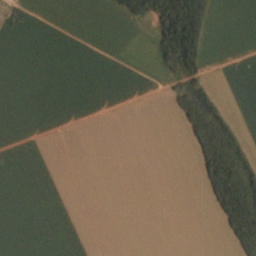

In [7]:
image_file = Image.open(path_train+'/train_32.jpg').convert("RGB")
display(image_file)

In [8]:
path_class = os.path.join(path, "train_classes.csv")
df_class = pd.read_csv(path_class)
print(df_class.shape)
df_class.head()

(40479, 2)


,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [9]:
df_class["list_tags"] = df_class.tags.str.split(" ")
row_tags = df_class.list_tags.values
tags = [tag for row in row_tags for tag in row]
counter_tags = Counter(tags)
df_tags = pd.DataFrame(
    {"tag": counter_tags.keys(), "total": counter_tags.values()}
).sort_values("total")

#fig = px.bar(df_tags, x="total", y="tag", orientation="h", color="total",)
#fig.update_layout(title="Class distribution")
# fig.show()


In [10]:
classes = df_tags["total"].sum()

In [11]:
RARE_CLASSES = [
    "bare_ground", "selective_logging", "artisinal_mine", "blooming", "slash_burn", "blow_down", "conventional_mine"
]

In [12]:
df_train, df_val = train_test_split(df_class, test_size=.2)
ds_train_size, ds_val_size = df_train['tags'].size, df_val['tags'].size
for rare_class in RARE_CLASSES:
    total_train = df_train.loc[df_train.tags.str.contains(rare_class)].shape[0]
    total_val = df_val.loc[df_val.tags.str.contains(rare_class)].shape[0]
    print(
        f"train {rare_class}: {100 * total_train / df_train.shape[0]:.4f}% ({total_train})")
    print(
        f"val {rare_class}: {100 * total_val / df_val.shape[0]:.4f}% ({total_val})\n")

train bare_ground: 2.1431% (694)
val bare_ground: 2.0751% (168)

train selective_logging: 0.8399% (272)
val selective_logging: 0.8399% (68)

train artisinal_mine: 0.8152% (264)
val artisinal_mine: 0.9264% (75)

train blooming: 0.8461% (274)
val blooming: 0.7164% (58)

train slash_burn: 0.5373% (174)
val slash_burn: 0.4323% (35)

train blow_down: 0.2501% (81)
val blow_down: 0.2100% (17)

train conventional_mine: 0.2378% (77)
val conventional_mine: 0.2841% (23)



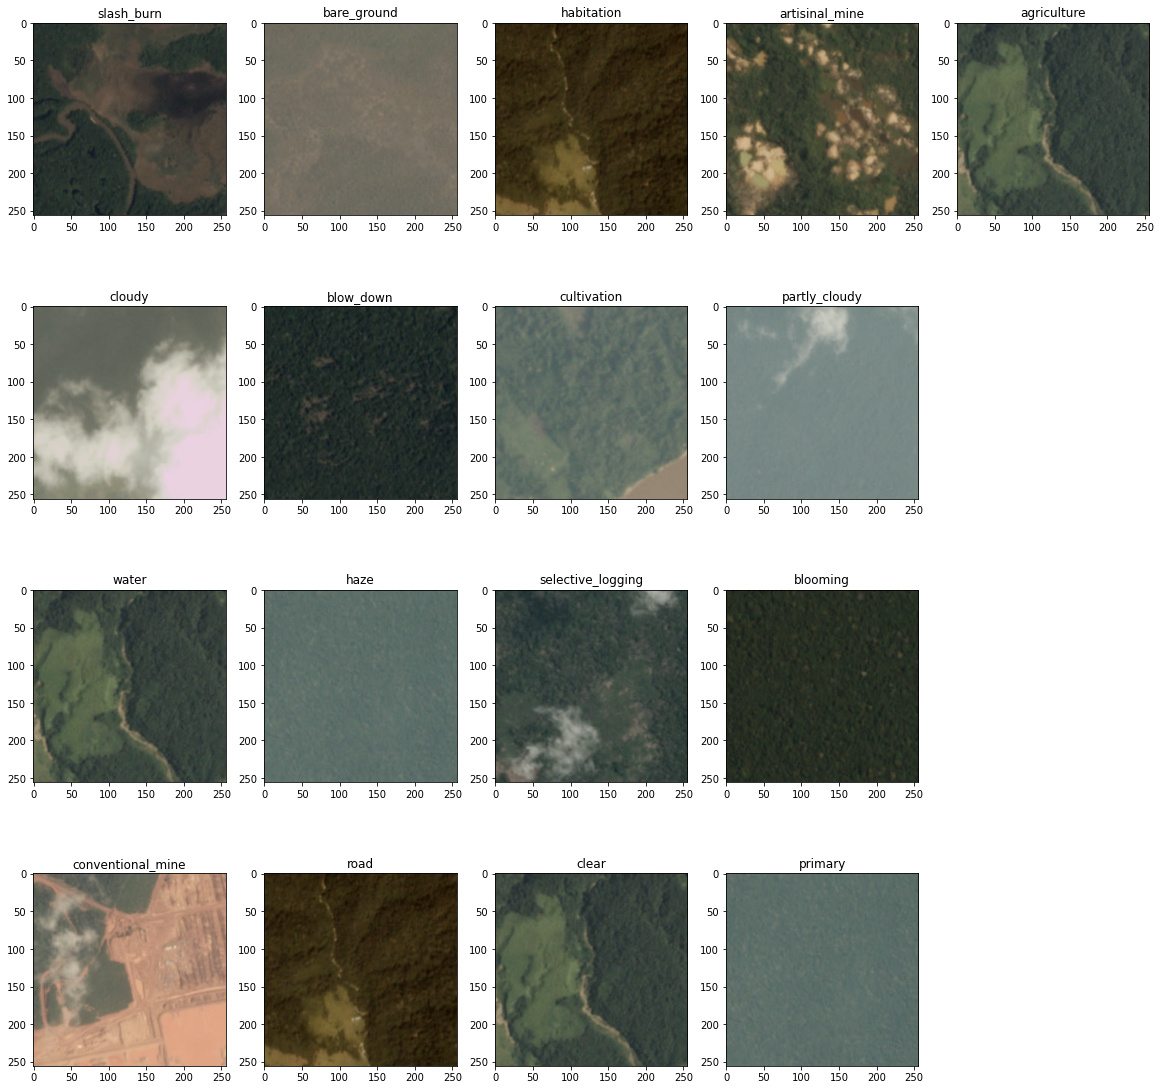

In [13]:
all_tags = list(set(tags))
N_tags = len(all_tags)
fig, axes = plt.subplots(4, (N_tags//4)+1, figsize=(20, 20))
for idx, tag in enumerate(all_tags):
    filename = df_class.loc[df_class.tags.str.contains(
        tag)].image_name.values[0]
    img = cv2.imread(os.path.join(path_train, filename+".jpg"))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    idx_col = idx // 4
    idx_row = idx % 4
    axes[idx_row][idx_col].set_title(tag)
    axes[idx_row][idx_col].imshow(img)
axes[1][-1].remove()
axes[2][-1].remove()
axes[3][-1].remove()

In [14]:
def load_img(path_file):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (100, 100), cv2.INTER_LINEAR).astype(float)
    img = cv2.normalize(img, None, 0.0, 1.0, cv2.NORM_MINMAX)
    img = img.reshape(1, -1)
    return img

In [15]:
filenames = df_class.image_name.sample(600).values
path_files = [os.path.join(path_train, filename+".jpg")
              for filename in filenames]
X_train_sample = np.vstack([load_img(path_file) for path_file in path_files])
X_train_sample.shape

(600, 30000)

In [16]:
def fetch_img(path_file, h, w):
    img = cv2.imread(path_file)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (h*2, w*2), cv2.INTER_LINEAR)
    return img

In [17]:
def tsne_analysis():

    tsne = TSNE(
        n_components=2,
        init="random",
        random_state=101,
        method="barnes_hut",
        n_iter=500,
        verbose=2,
    )
    X_embedded = tsne.fit_transform(X_train_sample)
    X_embedded.shape

    size_img = 1000
    offset_img = 50
    h = w = int(offset_img / 2)

    X_scaled = (X_embedded - X_embedded.min(0)) / \
        (X_embedded.max(0) - X_embedded.min(0))
    X_scaled = (X_scaled * size_img).astype(int)
    X_scaled = np.clip(X_scaled, offset_img, size_img-offset_img)

    img_tsne = np.ones((size_img+2*offset_img, size_img+2 *
                       offset_img, 3), dtype=np.uint8) * 255
    for idx in range(X_scaled.shape[0]):
        x, y = X_scaled[idx][0], X_scaled[idx][1]
        img = fetch_img(path_files[idx], h, w)
        img_tsne[x-w:x+w, y-h:y+h, :] = img

    fig = plt.figure(figsize=(12, 12))
    plt.imshow(img_tsne)
    plt.axis("off")
# tsne_analysis()


# Dataset prep

In [18]:
# create image augmentations
transform_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ]
)

transform_val = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        T.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ]
)

In [19]:
class AmazonDatasetError(Exception):
    pass


class AmazonDataset(Dataset):
    def __init__(self, df, ohe_tags, transform, path, is_train=True, idx_tta=None):
        super().__init__()
        self.df = df
        self.ohe_tags = ohe_tags
        self.transform = transform_train
        if isinstance(path, str):
            self.paths = [path]
        elif isinstance(path, (list, tuple)):
            self.paths = path
        else:
            raise AmazonDatasetError(
                f"Path type must be str, list or tuple, got: {type(path)}")
        self.is_train = is_train
        self.idx_tta = idx_tta

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        filename = self.df.iloc[idx].image_name + ".jpg"
        for path in self.paths:
            if filename in os.listdir(path):
                file_path = os.path.join(path, filename)
                break
        else:
            raise AmazonDatasetError(
                f"Can't fetch {filename} among {self.paths}")
        image = Image.open(file_path).convert("RGB")
        label = self.ohe_tags[idx]
        return image, label

    def collate_fn(self, batch):
        imgs, labels = [], []
        for (img, label) in batch:
            img = self.transform(img)
            img.permute(2, 0, 1)
            imgs.append(img[None])
            labels.append(label[None])
        imgs = torch.cat(imgs).float()
        labels = torch.cat(labels).float()
        return imgs, labels

    def load_img(self, idx, ax=None):
        img, ohe_label = self[idx]
        label = self.df.iloc[idx].tags
        title = f"{label} - {ohe_label} - {self.transform(img).shape}"
        if ax is None:
            plt.imshow(img)
            plt.title(title)
        else:
            ax.imshow(img)
            ax.set_title(title)


In [20]:
#from multiprocessing import set_start_method
#multiprocessing_context = torch.multiprocessing.set_start_method('spawn')

def get_data(df_train, df_val):

    encoder = MultiLabelBinarizer()
    ohe_tags_train = torch.tensor(
        encoder.fit_transform(df_train.list_tags.values))
    ohe_tags_val = torch.tensor(encoder.transform(df_val.list_tags.values))

    ds_train = AmazonDataset(df_train, ohe_tags_train,
                             transform_train, path=path_train)
    ds_val = AmazonDataset(df_val, ohe_tags_val,
                           transform_val, path=path_train)

    sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0)
    sample_weights = sample_weights.double()
    sampler = torch.utils.data.WeightedRandomSampler(
        sample_weights, len(sample_weights))

    dl_train = DataLoader(
        ds_train,
        batch_size=BATCH_SIZE,
        collate_fn=ds_train.collate_fn,
        # sampler=sampler,
        shuffle=True,
        prefetch_factor=3,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        # persistent_workers=True,
        #multiprocessing_context = multiprocessing_context
    )
    dl_val = DataLoader(
        ds_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
        collate_fn=ds_val.collate_fn,
        prefetch_factor=3,
        pin_memory=True,
        num_workers=2,
        drop_last=True,
        # persistent_workers=True,
        #multiprocessing_context = multiprocessing_context
    )

    return ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train


In [21]:
ds_train, ds_val, dl_train, dl_val, encoder, ohe_tags_train = get_data(df_train, df_val)

def untest_loader():
  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

  imgs, labels = next(iter(dl_train))
  print(imgs.shape, labels.shape)

untest_loader()

torch.Size([64, 3, 224, 224]) torch.Size([64, 17])
torch.Size([64, 3, 224, 224]) torch.Size([64, 17])


# Utilities functions

In [22]:
def load_checkpoint(filename):
    try:
        checkpoint = torch.load(filename, map_location=torch.device(device))
        print(checkpoint.keys())
        epoch = checkpoint['epoch']
        model_state = checkpoint['model']
        optimizer_state = checkpoint['optimizer']
        lr_scheduler_state = checkpoint['lr_scheduler']
        max_accuracy = checkpoint['max_accuracy']
        epoch = checkpoint['epoch']
        #config = checkpoint['config']
        return checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy
    except:
        print("Not able to load checkpoint ",filename)


def load_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        score = results['score']
        loss = results['loss']
        y_epochs = results['y']
        Y_thresh = results['Y_thresh']
        configs = results['config']
        epochs = results['epoch']
        max_accuracy = results['max_accuracy']

        return results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy

    except Exception as e:
        print("Not able to load results")
        print(e)  


def remove_file(path):
    if OVERWRITE_CHECKPOINT:
        try:
            os.remove(path)
            print(f"File {path} removed")
            return
        except Exception as e:
            print(e) 
    print(f"Not able to remove {path}")  

def save_overwrite_checkpoints(checkpoint, file):
    remove_file(file)
    torch.save(checkpoint, file)
    print(f"File {file} updated")


def save_overwrite_results(results, file):
    remove_file(file)
    pickle.dump(results, open(file, "wb+"))    
    print(f"File {file} updated")

def print_arch():
  print([module for module in model.modules() if not isinstance(module, nn.Sequential)])
    
def print_weights():
    kl = list()
    #unfreeze_param = ["relative_position_index", "relative_coords_table", "attn_mask", "head", "relative_position_bias_table", "absolute_pos_embed"]
    unfreeze_param = ["head", "layers.3.blocks.1.mlp, layers.3.downsample.norm"]
    unfreeze_param = ["layers.3.blocks.1."]
    #unfreeze_param = ["head"]
    for k, v in model.state_dict().items():
        #v.requires_grad = False
        print(f"{k} requires grad {v.float().requires_grad}")
        for parameter in unfreeze_param:
            if parameter in k:
                freeze=False
                v=v.float()
                print(k,v)
                #v.requires_grad = True 
                print(f"unfreeze {k}")
                break
            freeze=True

        if freeze:
            #v.requires_grad = freeze
            kl.append(k)
            #print( k)  


# Model

## Loading pre-trained weights/checkpoints

In [23]:
if RECOVER_PAST_TRAINNING:
    checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(checkpoint_path)
    results, score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(results_path)
    print("recover_training")
else:
    if MODEL == 'resnet50_IMAGENET':
        model = models.resnet.resnet50(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    elif MODEL == 'swin_t_IMAGENET':
        model = models.swin_transformer.swin_t(weights='IMAGENET1K_V1')
        model_state = model.state_dict()
    else:
        checkpoint, epoch, model_state, optimizer_state, lr_scheduler_state, max_accuracy = load_checkpoint(weights_path)
    results = {}

dict_keys(['model', 'optimizer', 'lr_scheduler', 'max_accuracy', 'epoch', 'config'])


In [24]:
import timm
#https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html
def build_model_resnet_50(model_state):

    model = models.resnet50()

    del model_state['fc.weight']
    del model_state['fc.bias']
    info = model.load_state_dict(model_state, strict=False)

    for param in model.parameters():
        param.require_grad = False
      
    model.fc = nn.Sequential(
      nn.Linear(2048, 17), # 512 for resnet18 or 2048 for resnet 50
      nn.Sigmoid()
    )     

#    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
#    model.fc = nn.Sequential(
#      nn.Flatten(),
#      nn.Linear(2048, 128), # 512 for resnet18 or 2048 for resnet 50
#      nn.ReLU(inplace=True),
#      nn.Dropout(.2),
#      nn.Linear(128, 17),
#      nn.Sigmoid())
    
    return model.to(device)


if MODEL == 'rsp-resnet-50':
    model = build_model_resnet_50(model_state)

In [25]:
def build_model_swan_t(model_state):
    model = timm.models.swin_tiny_patch4_window7_224()
    state_dict = model_state

    num_classes = 17
    swin_embed_dim = 768

    # assuming that the head layer has 768 neurons, otherwise change it
    model.head = nn.Linear(swin_embed_dim, num_classes)
    #torch.nn.Sequential(model, torch.nn.Sigmoid())

    model = model.to(device)
    state_dict = model.state_dict()

    # delete relative_position_index since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_position_index" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete relative_coords_table since we always re-init it
    relative_position_index_keys = [k for k in state_dict.keys() if "relative_coords_table" in k]
    for k in relative_position_index_keys:
        del state_dict[k]

    # delete attn_mask since we always re-init it
    attn_mask_keys = [k for k in state_dict.keys() if "attn_mask" in k]
    for k in attn_mask_keys:
        del state_dict[k]

    state_dict = model_state

    del state_dict['head.weight']
    del state_dict['head.bias']
    torch.nn.init.constant_(model.head.bias, 0.)
    torch.nn.init.constant_(model.head.weight, 0.)

    info = model.load_state_dict(state_dict, strict=False)
    model.head = nn.Linear(swin_embed_dim, num_classes)
    print(info)
    model = torch.nn.Sequential(model, torch.nn.Sigmoid())
    torch.cuda.empty_cache()

    return model.to(device)


if MODEL == 'rsp-swin-t':
    model = build_model_swan_t(model_state)



# Train setup

In [26]:
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(FocalLoss, self).__init__()

    def forward(self, inputs, targets, alpha=0.8, gamma=2, smooth=1):     
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #first compute binary cross-entropy 
        BCE = F.binary_cross_entropy(inputs, targets, reduction='mean')
        BCE_EXP = torch.exp(-BCE)
        focal_loss = alpha * (1-BCE_EXP)**gamma * BCE
                       
        return focal_loss.to(device)

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False


In [27]:
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
lr_scheduler = ReduceLROnPlateau(optimizer, cooldown=2, factor=0.5, verbose=True, patience=10)
early_stopper = EarlyStopper(patience=2)
# https://pytorch.org/docs/stable/generated/torch.nn.BCEWithLogitsLoss.html
sample_weights = ohe_tags_train.shape[0]/ohe_tags_train.sum(axis=0) - 1
sample_weights = sample_weights.double().to(device)
#loss_fn = nn.BCELoss(weight=sample_weights)  # Binary Cross Entropy
#loss_fn = nn.BCELoss()  # Binary Cross Entropy
loss_fn = FocalLoss()
sample_weights


tensor([2.2826e+00, 1.2166e+02, 4.5661e+01, 1.1719e+02, 3.9879e+02, 4.2562e-01,
        1.8241e+01, 4.1956e+02, 8.0785e+00, 1.0082e+01, 1.4104e+01, 4.5450e+00,
        8.0009e-02, 4.0183e+00, 1.1806e+02, 1.8511e+02, 4.5111e+00],
       device='cuda:0', dtype=torch.float64)

# Train Helper functions

In [28]:
def fit_batch(X, Y, model, loss_fn, optimizer):
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    batch_loss.backward()
    optimizer.step()
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()


@torch.no_grad()
def compute_val_loss(X, Y, model, loss_fn):
    model.eval()
    Y_hat = model(X.to(device))
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()

    return Y_hat, batch_loss.item()
# Test batch train

def unit_test_batch_train():
    X, Y = next(iter(dl_train))
    model.train()
    optimizer.zero_grad()
    Y_hat = model(X.to(device))
    Y_hat[Y_hat < 0]
    batch_loss = loss_fn(Y_hat, Y.to(device))
    Y_hat = Y_hat.detach()
    
unit_test_batch_train()

In [29]:
def init_arrays(train_baches_epoch, val_baches_epoch):
    train_baches_epoch, val_baches_epoch = int(train_baches_epoch), int(val_baches_epoch)
    loss = dict()
    loss["train"] = np.zeros((N_EPOCHS,train_baches_epoch))
    loss["val"] = np.zeros((N_EPOCHS,train_baches_epoch))
    lr = np.zeros((N_EPOCHS,train_baches_epoch))
    score = dict()
    score["val"] = np.zeros(N_EPOCHS)
    score["train"] = np.zeros(N_EPOCHS)

    y_epoch = {'train': dict(), 'val': dict()}
    y_epoch["train"]["label"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["train"]["pred"] = torch.zeros((N_EPOCHS, train_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["label"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))
    y_epoch["val"]["pred"] = torch.zeros((N_EPOCHS, val_baches_epoch, BATCH_SIZE, FEATURES))

    return y_epoch, score, loss, lr
    
train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE
y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
print(train_steps)
print(y_epoch["train"]["label"][N_EPOCHS-1][train_steps-1][BATCH_SIZE-1][FEATURES-1])

505
tensor(0.)


In [30]:
def eval_score(Y_true:Tensor, Y_pred:Tensor, threshold:float):
    Y_true = Y_true.cpu().numpy().reshape((-1,FEATURES))
    Y_pred = (Y_pred.cpu().numpy() > .2).astype(float).reshape((-1,FEATURES))
    return fbeta_score(Y_true,Y_pred,beta=2, average="samples")

t1, t2 = torch.zeros(FEATURES), torch.zeros(FEATURES)
t1[4], t2[7] = 1, 1
Y_true = torch.cat([t1,t2])
Y_pred = torch.cat([t2,t1])*0.8
print(Y_true)
print(Y_pred)
eval_score(Y_true, Y_pred, 0.5)

tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.8000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.8000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])


0.0

# Train

In [31]:
if RunningInCOLAB:
    torch.cuda.empty_cache()
gc.collect()

163

In [32]:
def train_model(dl_train, dl_val, version, model, optimizer, loss_fn, lr_scheduler, results, checkpoint):
    train_steps, val_steps = ds_train_size//BATCH_SIZE, ds_val_size//BATCH_SIZE

    y_epoch, score, loss, lr = init_arrays(train_steps, val_steps)
    epoch_start = 0
    if results and RECOVER_PAST_TRAINNING:
        train_results = deepcopy(results)
        epoch_start = checkpoint['epoch']
        best_score_val = train_results["score_val"]
        lr_scheduler = checkpoint['lr_scheduler']
        
    Y_val, Y_hat = torch.zeros(FEATURES), torch.zeros(FEATURES)
    best_loss_val, best_score_val = torch.inf, 0
    Y_thresh_val = 0.2
    batch_loss = torch.inf
    for epoch in range(epoch_start, N_EPOCHS):

        for idx, (X, Y) in enumerate(tqdm(dl_train, leave=False)):
            Y_hat, batch_loss = fit_batch(X, Y, model, loss_fn, optimizer)
            loss["train"][epoch][idx] = batch_loss
            y_epoch["train"]["pred"][epoch][idx] = Y_hat
            y_epoch["train"]["label"][epoch][idx] = Y
            lr[epoch][idx] = optimizer.param_groups[0]['lr']
            if idx > 0 and idx % LR_STEP_SIZE == 0:
                avg_loss = loss["train"][epoch][idx-LR_STEP_SIZE:idx+1].mean()
                it_score = eval_score(Y,Y_hat,Y_thresh_val)
                print(f'Train Loss: {avg_loss} score:{it_score}')
                lr_scheduler.step(metrics=avg_loss)
            #break

        for idx, (X, Y) in enumerate(tqdm(dl_val, leave=False)):
            Y_hat, batch_loss = compute_val_loss(X, Y, model, loss_fn)
            loss["val"][epoch][idx] = batch_loss
            y_epoch["val"]["pred"][epoch][idx] = Y_hat
            y_epoch["val"]["label"][epoch][idx] = Y
            #break
        

        score['train'][epoch] = eval_score(y_epoch["train"]["label"][epoch],
                                          y_epoch["train"]["pred"][epoch], Y_thresh_val)
        score['val'][epoch] = eval_score(y_epoch["val"]["label"][epoch],
                                        y_epoch["val"]["pred"][epoch], Y_thresh_val)

        avg_loss_train = loss["train"][epoch].mean()
        avg_loss_val = loss["val"][epoch].mean()

        best_loss_val = avg_loss_val if avg_loss_val < best_loss_val else best_loss_val
        best_score_val = score['val'][epoch] if best_score_val < score['val'][epoch] else best_score_val


        print(
            f"epoch: {epoch}/{N_EPOCHS} -- train loss: {avg_loss_train}, "
            f"val loss: {avg_loss_val}"
            f" -- train fbeta_score: {score['train'][epoch]}, "
            f"val fbeta_score: {score['val'][epoch]}"
        )

        checkpoint = {
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'loss': best_loss_val,
            'max_accuracy': best_score_val,
            'best_loss_val': best_loss_val,
            'lr_scheduler': lr_scheduler.state_dict(),
            'config': config
        }

        results = {
            "loss": loss,
            "score": score,
            "y": y_epoch,
            'epoch': epoch,
            'best_loss_val': best_loss_val,
            'max_accuracy': best_score_val,
            'config': config,
            'Y_thresh' : Y_thresh_val,
            'lr':lr
        }
        

        if best_score_val <= score['val'][epoch]:
            save_overwrite_checkpoints(checkpoint, checkpoint_path)
        save_overwrite_results(results, results_path)

        if early_stopper.early_stop(score['val'][epoch]):             
           pass
           #break

        #break


train_model(dl_train, dl_val, VERSION, model, optimizer, loss_fn, lr_scheduler, results, checkpoint)


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.060520489159370625 score:0.7296788094099047
Train Loss: 0.007865892212477422 score:0.8490032208517039
Train Loss: 0.0037945652335521674 score:0.8808069369400492
Train Loss: 0.00283908755743816 score:0.8608272730765137
Train Loss: 0.0024028482636617074 score:0.8819728795002268
Train Loss: 0.0018278677241816636 score:0.8997448344154817
Train Loss: 0.0017302446442866517 score:0.8602937560277198
Train Loss: 0.0015156035059912792 score:0.8974833889026104
Train Loss: 0.001230651424491718 score:0.9272047238968595
Train Loss: 0.0012720687682890603 score:0.8852347888335182
Train Loss: 0.0011621389637566021 score:0.8999568497941901
Train Loss: 0.0010891702155687757 score:0.9220444732924595
Train Loss: 0.0011162042060130907 score:0.895580018326366
Train Loss: 0.0011659990207502438 score:0.926373439400118
Train Loss: 0.0009922649131171525 score:0.8933337408747696
Train Loss: 0.0009704835219083414 score:0.8989290984971284


  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 0/6 -- train loss: 0.0055842763493021965, val loss: 0.00024026079578232942 -- train fbeta_score: 0.8667870115111672, val fbeta_score: 0.904779447797549
[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth'
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl'
Not able to remove /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.000976663904317144 score:0.9400271447036552
Train Loss: 0.0008898095036255977 score:0.9216848185541924
Train Loss: 0.0008875451110784084 score:0.8904290579012846
Train Loss: 0.0008359244844365505 score:0.861154200691334
Train Loss: 0.0007384154258386022 score:0.8877618586763099
Train Loss: 0.0007399579973876357 score:0.921317624302427
Train Loss: 0.0009512772714163387 score:0.903170848759084
Train Loss: 0.000762070038153099 score:0.8954267313100666
Train Loss: 0.0007622554586569388 score:0.9188709594435935
Train Loss: 0.0008407159024969705 score:0.8661986983136513
Train Loss: 0.0008051839428052547 score:0.9362185073566296
Train Loss: 0.0008008776865373816 score:0.9291942097415685
Train Loss: 0.0007089074356518986 score:0.9094693157591459
Train Loss: 0.0007791295027991216 score:0.8685924565126684
Train Loss: 0.000674573736990081 score:0.9245561573994963
Train Loss: 0.0006861450533652978 score:0.907928898585237


  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 1/6 -- train loss: 0.0007986447108808057, val loss: 0.000159120326170163 -- train fbeta_score: 0.9137642499362091, val fbeta_score: 0.9196881507336855
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.0006445712032502577 score:0.9185586440835711
Train Loss: 0.0006186901648048192 score:0.9288159409738157
Train Loss: 0.0005680214606165405 score:0.9400051371558724
Train Loss: 0.0006431725388768339 score:0.9334895826473222
Train Loss: 0.0006251887337590057 score:0.8700142752512477
Train Loss: 0.0006006298579215523 score:0.9315424049253258
Train Loss: 0.0005995953115709727 score:0.8749242604929042
Train Loss: 0.0006868547512098185 score:0.9220831847210524
Train Loss: 0.0005963155788542222 score:0.9056428000077623
Train Loss: 0.0005312995509161885 score:0.9207711675557382
Train Loss: 0.0005925708800561786 score:0.9155718951413768
Train Loss: 0.0006687101173860531 score:0.9010702011705358
Train Loss: 0.0006625831789983015 score:0.9476978189294366
Train Loss: 0.0005461913434931287 score:0.9369694076147562
Train Loss: 0.0006203702763624249 score:0.9247954089553199
Train Loss: 0.000642473436704266 score:0.9358931744687294


  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 2/6 -- train loss: 0.0006140740075676546, val loss: 0.0001645086470318239 -- train fbeta_score: 0.9211861643393285, val fbeta_score: 0.9204508114563226
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.0005725055652287518 score:0.934095930445987
Train Loss: 0.0005297019106951813 score:0.937895516184642
Train Loss: 0.00046973542644522125 score:0.9397614797916851
Train Loss: 0.0005497250381121112 score:0.9073597293672174
Train Loss: 0.0005592009772719334 score:0.9004792308509189
Train Loss: 0.0005319079143866416 score:0.926072956597837
Train Loss: 0.0004888723326017029 score:0.8868545840053192
Train Loss: 0.000561665153063293 score:0.9378625466609525
Train Loss: 0.00047819134112702863 score:0.913583865820591
Train Loss: 0.0006447591482766814 score:0.9294432177800986
Train Loss: 0.000524141765180825 score:0.9145618921750178
Train Loss: 0.00048595683314957684 score:0.9474214194056829
Train Loss: 0.000500188447580102 score:0.906857400412088
Train Loss: 0.00048475725963080844 score:0.918856461984743
Epoch 00062: reducing learning rate of group 0 to 5.0000e-05.
Train Loss: 0.0005003381633169709 score:0.9359239218348159
Train Loss: 0.0005216885169389688 score:0.9212285887553783

  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 3/6 -- train loss: 0.0005286463760652137, val loss: 0.0001336937922538295 -- train fbeta_score: 0.9249600329751083, val fbeta_score: 0.9234820877508294
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.0004143363170911588 score:0.941815515366091
Train Loss: 0.0004472406858000003 score:0.9485594031284479
Train Loss: 0.0005106376188303975 score:0.9169104841293225
Train Loss: 0.00044889103587446435 score:0.9499521674441584
Train Loss: 0.00034754048852670577 score:0.9172265322025013
Train Loss: 0.0004606643112398864 score:0.9246857191255569
Train Loss: 0.0004057656976416887 score:0.9497585762140077
Train Loss: 0.00040346246744100484 score:0.9248476080471676
Train Loss: 0.0003927402466351557 score:0.9341481294713219
Train Loss: 0.00039647074792751924 score:0.898498186607102
Train Loss: 0.00044518909435869465 score:0.9249088438257362
Train Loss: 0.0005098986615438105 score:0.9040769012602894
Train Loss: 0.00047836172668593783 score:0.9259260844213337
Train Loss: 0.00037104573857504874 score:0.9589998029433013
Train Loss: 0.00048168174192054017 score:0.9318133753662488
Train Loss: 0.0003661256703180111 score:0.9197946993425177
Epoch 00080: reducing learning rate of group 0 to 

  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 4/6 -- train loss: 0.0004294414353461263, val loss: 0.00012294819427534275 -- train fbeta_score: 0.9307178210752093, val fbeta_score: 0.9258960707332906
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


  0%|          | 0/505 [00:00<?, ?it/s]

Train Loss: 0.0003600354818533355 score:0.9142627170318345
Train Loss: 0.0003642701506783675 score:0.955591922297385
Train Loss: 0.00040991109140562797 score:0.9055829192414913
Train Loss: 0.00037804731677639326 score:0.9490661897106022
Train Loss: 0.00039684802346352127 score:0.9314586397820803
Train Loss: 0.0003286457424344976 score:0.9272618615799162
Train Loss: 0.0003618312501555098 score:0.8846819550667963
Train Loss: 0.00041091851674155484 score:0.925285203017764
Train Loss: 0.0003366383968950099 score:0.9271842221610445
Train Loss: 0.0004065162157207998 score:0.9418486205312006
Train Loss: 0.00033732473750733923 score:0.9503823515620875
Train Loss: 0.00039572613323182466 score:0.9590475831713554
Train Loss: 0.0003502131620470825 score:0.9366710266508302
Train Loss: 0.0003932189856347958 score:0.9370643766522407
Train Loss: 0.000323190436897529 score:0.9141168055460335
Train Loss: 0.0003513779539066637 score:0.9159131744803184


  0%|          | 0/126 [00:00<?, ?it/s]

epoch: 5/6 -- train loss: 0.00036562649312136365, val loss: 0.0001233555223086231 -- train fbeta_score: 0.933828937337365, val fbeta_score: 0.9262612356681212
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/rsp-resnet-50_final.pth updated
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl removed
File /content/drive/MyDrive/Colab-Notebooks/checkpoints/train_results_rsp-resnet-50_final.pkl updated


In [33]:
#files.download(results_path)
#files.download(checkpoint_path)

In [34]:
#!sleep 600

In [ ]:
runtime.unassign()

# Analysis

In [ ]:
score, loss, y_epochs, Y_thresh, configs, epochs, max_accuracy = load_results(checkpoint_path)

results, epoch, max_accuracy, config = load_train_results(filename):
    try:
        results = dict()
        results = pickle.load(open(filename,"rb"))
        epoch = results['epoch']
        max_accuracy = results['max_accuracy']
        epoch = results['epoch']
        config = results['config']
        return results, epoch, max_accuracy, config
    except:
        print("Not able to load results")

In [ ]:
oss_train = train_results["loss_train"]
loss_val = train_results["loss_val"]
score_train = train_results["score_train"]
score_val = train_results["score_val"]

fig = make_subplots(rows=1, cols=2, subplot_titles=("Loss", "Fbeta scores"))
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_train))),
        y=loss_train,
        name="loss_train",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(loss_val))),
        y=loss_val,
        name="loss_val",
    ),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_train))),
        y=score_train,
        name="score_train",
    ),
    row=1, col=2
)
fig.add_trace(
    go.Scatter(
        x=list(range(len(score_val))),
        y=score_val,
        name="score_val",
    ),
    row=1, col=2
)
fig.show()


In [ ]:
Y_hat_val = np.array(train_results["Y_hat_val"])
Y_val = np.array(train_results["Y_val"])

pos_probas, neg_probas = [], []
for class_, idx in encoder._cached_dict.items():
    pos_probas.append(Y_hat_val[np.where(Y_val[:, idx] != 0), idx].mean())
    neg_probas.append(Y_hat_val[np.where(Y_val[:, idx] == 0), idx].mean())
go.Figure([
    go.Bar(x=list(encoder._cached_dict),
           y=pos_probas, name="Y_hat proba | Y = 1"),
    go.Bar(x=list(encoder._cached_dict),
           y=neg_probas, name="Y_hat proba | Y = 0")
]).show()


In [ ]:


def find_best_thresholds(Y_hat, Y):
    N_tags = Y.shape[1]
    best_threshs = [0.2] * N_tags
    resolution = 100
    for jdx in tqdm(range(N_tags)):
        best_score = 0
        #threshs = np.zeros_like(best_threshs)
        threshs = best_threshs.copy()
        for kdx in range(resolution):
            kdx /= resolution
            threshs[jdx] = kdx
            Y_hat_thresh = (Y_hat > threshs).astype(float)
            score = fbeta_score(Y, Y_hat_thresh, beta=2, average="samples")
            if score > best_score:
                best_score = score
                best_threshs[jdx] = kdx

    global_best_score = fbeta_score(
        Y, (Y_hat > best_threshs).astype(float), beta=2, average="samples")
    print(f"threshs: {best_threshs} -- best score: {global_best_score}")

    return best_threshs


In [ ]:
threshs = find_best_thresholds(Y_hat_val, Y_val)


In [ ]:
class_scores = {}
classes = encoder.classes_
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    score = fbeta_score(y_val, y_hat_val, beta=2)
    class_scores[classes[jdx]] = round(score, 4)

df_score = pd.DataFrame(dict(
    label=list(class_scores.keys()), score=list(class_scores.values()),
)).sort_values("score", ascending=False)
fig = px.bar(df_score, x="label", y="score", color="score")
fig.show()


In [ ]:
fig = make_subplots(cols=5, rows=4)
for jdx in range(Y_val.shape[1]):
    y_val = Y_val[:, jdx].ravel()
    y_hat_val = (Y_hat_val[:, jdx].ravel() > threshs[jdx]).astype(float)
    tn, fp, fn, tp = confusion_matrix(y_val, y_hat_val).ravel()
    mat = np.array([[fn, tn], [tp, fp]])
    col = jdx // 4+1
    row = jdx % 4+1
    fig.add_trace(
        go.Heatmap(
            z=mat, text=[[f"fn: {fn}", f"tn: {tn}"],
                         [f"tp: {tp}", f"fp: {fp}"]],
            texttemplate="%{text}", colorscale='Viridis', name=encoder.classes_[jdx],
            showscale=False
        ),
        col=col, row=row,
    )
    fig.update_xaxes(title=encoder.classes_[
                     jdx], showticklabels=False, row=row, col=col)
    fig.update_yaxes(showticklabels=False, row=row, col=col)


fig.update_layout(
    width=1200, height=800, title="Confusion matrices",
)
fig.show()


In [ ]:
!echo $(ls ../input/planets-dataset/planet/planet/test-jpg | wc - l) + $(ls ../input/planets-dataset/test-jpg-additional/test-jpg-additional | wc - l)


In [ ]:
def get_test_data(idx_tta):
    path_test_table = "../input/planets-dataset/planet/planet"
    path_test_file_1 = "../input/planets-dataset/planet/planet/test-jpg"
    path_test_file_2 = "../input/planets-dataset/test-jpg-additional/test-jpg-additional"
    file_count = len(os.listdir(path_test_file_1)) + \
        len(os.listdir(path_test_file_2))
    df_test = pd.read_csv(os.path.join(
        path_test_table, "sample_submission.csv"))

    assert df_test.shape[0] == file_count  # sanity check

    ohe_tags_test = np.zeros((df_test.shape[0], 17))
    _, transform_val = get_transforms()
    ds_test = AmazonDataset(
        df_test, ohe_tags_test, transform_val, path=[
            path_test_file_1, path_test_file_2],
        is_train=False, idx_tta=idx_tta
    )
    dl_test = DataLoader(
        ds_test, shuffle=False, batch_size=32, collate_fn=ds_test.collate_fn
    )

    return dl_test, df_test


In [ ]:
@torch.no_grad()
def batch_predict(model, X):
    model.eval()
    Y = model(X)
    return Y.detach().float().cpu().numpy()


In [ ]:
Y_hat_test = []
for idx_tta in range(6):
    Y_hat_test_tta = []
    dl_test, df_test = get_test_data(idx_tta)
    for X, _ in tqdm(dl_test):
        Y_hat_test_batch = batch_predict(model, X)
        Y_hat_test_tta.extend(Y_hat_test_batch)
    Y_hat_test.append(Y_hat_test_tta)
Y_hat_test = np.mean(np.array(Y_hat_test), axis=0)
Y_hat_test = (Y_hat_test > threshs).astype(float)


In [ ]:
Y_hat_test_inv = encoder.inverse_transform(Y_hat_test)
test_tags = []
for row in Y_hat_test_inv:
    tags = " ".join(row)
    test_tags.append(tags)

df_test["tags"] = test_tags
df_test.to_csv("my_sample_submission.csv", index=False)
